In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import time

import lightgbm

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

from matplotlib.pyplot import figure

from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.kernel_ridge import KernelRidge

%matplotlib inline

In [2]:
rep_cols = {'ID':'ID', 
 '板温':'board_t', 
 '现场温度':'env_t', 
 '光照强度':'light_strength', 
 '转换效率':'efficiency', 
 '转换效率A':'efficiency_A', 
 '转换效率B':'efficiency_B', 
 '转换效率C':'efficiency_C', 
 '电压A':'V_A',
 '电压B':'V_B', 
 '电压C':'V_C', 
 '电流A':'I_A', 
 '电流B':'I_B', 
 '电流C':'I_C', 
 '功率A':'P_A', 
 '功率B':'P_B', 
 '功率C':'P_C', 
 '平均功率':'P_avg', 
 '风速':'wind_speed',
 '风向':'wind_direction', 
 '发电量':'y'
}

In [3]:
def my_val(preds, train_data):
    label = train_data.get_label()
    return 'score', 1/(1+np.sqrt(mean_squared_error(preds, label))), True
def my_obj(preds, train_data):
    labels = train_deata.get_label()

In [4]:
train = pd.read_csv('../data/public_raw.train.csv')
test = pd.read_csv('../data/public_raw.test.csv')

train_len = train.shape[0]

train['is_train']=1
test['is_train']=0

df = pd.concat([train, test],sort=False)

In [5]:
df.rename(index=str, columns=rep_cols, inplace=True)

df.sort_values(by=['ID'],ascending=True, inplace=True)

df.reset_index(drop=True, inplace=True)

In [6]:
#电压电流存在异常测量值标记为1
df['to_correct'] = 0

In [7]:
#电压异常值处理
correct_dict = {
    'V_A':(480,60000),
    'V_B':(500,60000),
    'V_C':(500,60000),
}

for c in correct_dict.keys():
    df[c+'_filtered'] = df[c]
    df[c+'_filtered'][(df['I_A']>0)&((df[c]>correct_dict[c][1]) | (df[c]<correct_dict[c][0]))   ] = np.nan 
    
    df['to_correct'][(df['I_A']>0)&((df[c]>correct_dict[c][1]) | (df[c]<correct_dict[c][0]))   ] = 1
#     df['to_correct'][(df[c]>correct_dict[c][1]) | ((df[c]<correct_dict[c][0]) & (df[c]>0))] = 1

C:\Users\Alex\Anaconda3\envs\python36\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Alex\Anaconda3\envs\python36\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


In [8]:
#前二后二
next_one = []
prev_one = []
next_id = []
prev_id = []

second_next_one = []
second_prev_one = []

df_len = df.shape[0]

i_y =df.columns.get_loc("y")

def get_prev_nn_index(cur_i):
    prev_i = cur_i-1
    while(prev_i>=0 and pd.isnull(df.iat[prev_i,i_y])):
        prev_i-=1
    return prev_i

def get_next_nn_index(cur_i):
    prev_i = cur_i+1
    while(prev_i<df_len and pd.isnull(df.iat[prev_i,i_y])):
        prev_i+=1
    return prev_i

for i in range(df_len):
    f_pre_i=get_prev_nn_index(i)
    if(f_pre_i)<0:
        prev_one.append(np.nan)
        prev_id.append(0)
    else:
        prev_one.append(df.iat[f_pre_i,i_y])
        prev_id.append(f_pre_i)
        
    s_pre_i=get_prev_nn_index(f_pre_i)
    if (s_pre_i)<0:
        second_prev_one.append(np.nan)
    else:
        second_prev_one.append(df.iat[s_pre_i,i_y])
    
    f_next_i=get_next_nn_index(i)
    if(f_next_i<df_len):
        next_one.append(df.iat[f_next_i,i_y])
        next_id.append(f_next_i)
    else:
        next_one.append(np.nan)
        next_id.append(df_len)
    
    s_next_i=get_next_nn_index(f_next_i)
    if(s_next_i<df_len):
        second_next_one.append(df.iat[s_next_i,i_y])
    else:
        second_next_one.append(np.nan)

In [9]:
df['next_value'] = next_one
df['prev_value'] = prev_one
df['avg_value'] = np.nanmean([df['next_value'], df['prev_value']],axis=0)
df['next_ID'] = next_id
df['prev_ID'] = prev_id
# df['interpolation_ID'] = df['prev_value']+(df['ID']-df['prev_ID'])/(df['next_ID']-df['prev_ID'])*(df['next_value']-df['prev_value'])
# df['interpolation_ls'] = df['prev_value']+(df['light_strength']-df['prev_ls'])/(1+df['next_ls']-df['prev_ls'])*(df['next_value']-df['prev_value'])

df['second_prev_value'] = second_prev_one
df['second_next_value'] = second_next_one
# df['avg_value_four'] = np.nanmean([df['second_next_value'],df['next_value'], df['prev_value'],df['second_prev_value']],axis=0)


# df['rolling_seven'] = df['y'].rolling(7,center=True,min_periods=0).apply(lambda x: np.nanmean(x[[0,1,2,4,5,6]]))
# rolling_mask_two = [-i for i in range(1)]+[i for i in range(1)]
rolling_mask_two = [-i for i in range(1,2)]+[i for i in range(1,2)]
rolling_mask_four = [-i for i in range(1,3)]+[i for i in range(1,3)]
rolling_mask_six = [-i for i in range(1,4)]+[i for i in range(1,4)]
rolling_mask_eight = [-i for i in range(1,5)]+[i for i in range(1,5)]
# df['rolling_four_y'] = np.nanmean([df['y'].shift(i) for i in rolling_mask_four],axis=0)
df['rolling_six_y'] = np.nanmean([df['y'].shift(i) for i in rolling_mask_six],axis=0)
# df['rolling_eight_y'] = np.nanmean([df['y'].shift(i) for i in rolling_mask_eight],axis=0)
# df['rolling_eight_VA'] = np.nanmean([df['V_A'].shift(i) for i in rolling_mask_eight],axis=0)
# df['rolling_eight_VB'] = np.nanmean([df['V_B'].shift(i) for i in rolling_mask_eight],axis=0)
# df['rolling_eight_VC'] = np.nanmean([df['V_C'].shift(i) for i in rolling_mask_eight],axis=0)
df['rolling_six_VA'] = np.nanmean([df['V_A_filtered'].shift(i) for i in rolling_mask_six],axis=0)
df['rolling_six_VB'] = np.nanmean([df['V_B_filtered'].shift(i) for i in rolling_mask_six],axis=0)
df['rolling_six_VC'] = np.nanmean([df['V_C_filtered'].shift(i) for i in rolling_mask_six],axis=0)

#6 four 4!!!
df['rolling_four_IA'] = np.nanmean([df['I_A'].shift(i) for i in rolling_mask_six],axis=0)

C:\Users\Alex\Anaconda3\envs\python36\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: Mean of empty slice


In [10]:
#电压异常值处理
df['VA_corrected'] = df['V_A']
df.loc[df['V_A_filtered'].isnull(),'VA_corrected'] = df['rolling_six_VA']
# df['VA_corrected'][df['V_A_filtered']==np.nan] = df['rolling_six_VA'] 
df['VB_corrected'] = df['V_B']
df.loc[df['V_B_filtered'].isnull(),'VB_corrected'] = df['rolling_six_VB']
df['VC_corrected'] = df['V_C']
df.loc[df['V_C_filtered'].isnull(),'VC_corrected'] = df['rolling_six_VC']

In [11]:
#电流异常值处理
ratio_limit=1
df['IA_filtered'] = df['I_A']
df['IA_filtered'][(df['IA_filtered']>0)&(np.abs(df['I_A']-df['rolling_four_IA'])/df['rolling_four_IA']>ratio_limit)] = np.nan 
# df['IA_filtered'][np.abs(df['I_A']-df['rolling_four_IA'])/df['rolling_four_IA']>ratio_limit] = np.nan 
    
df['to_correct'][(df['IA_filtered']>0)&(np.abs(df['I_A']-df['rolling_four_IA'])/df['rolling_four_IA']>ratio_limit)] = 1

C:\Users\Alex\Anaconda3\envs\python36\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\Alex\Anaconda3\envs\python36\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [12]:
df['IA_corrected'] = df['I_A']
df.loc[df['IA_filtered'].isnull(),'IA_corrected'] = df['rolling_four_IA']

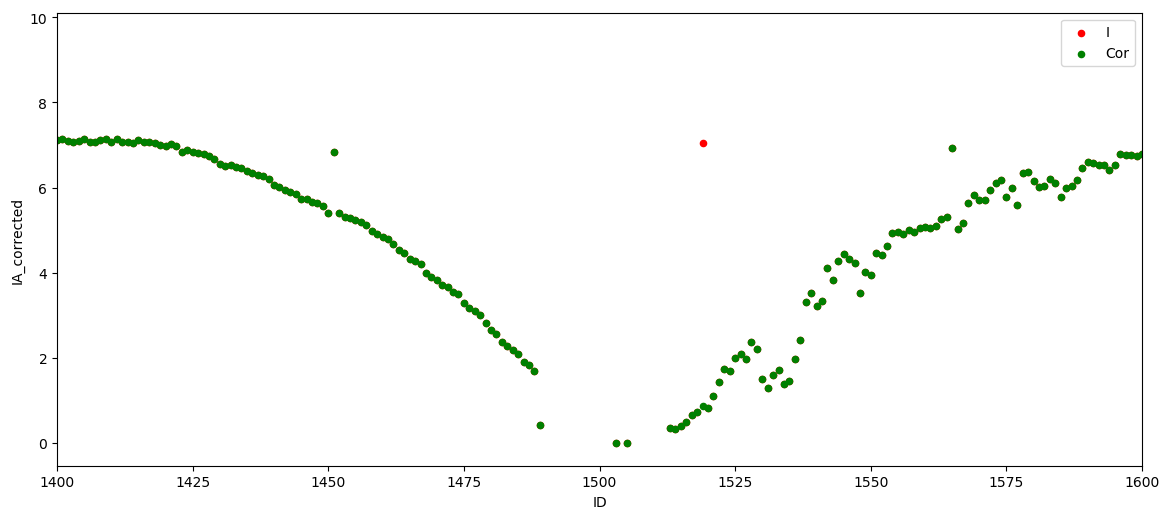

In [13]:
#ID 1894 所在周期
figure(num=None, figsize=(14, 6), dpi=100, facecolor='w', edgecolor='k')

ax = plt.gca()
# df.plot.scatter(x='ID',y='I_A',label='I',color='red',ax=ax)
df.plot.scatter(x='ID',xlim=(1500-100,1500+100),y='I_A',label='I',color='red',ax=ax)
df.plot.scatter(x='ID',y='IA_corrected',label='Cor',color='green',ax=ax)

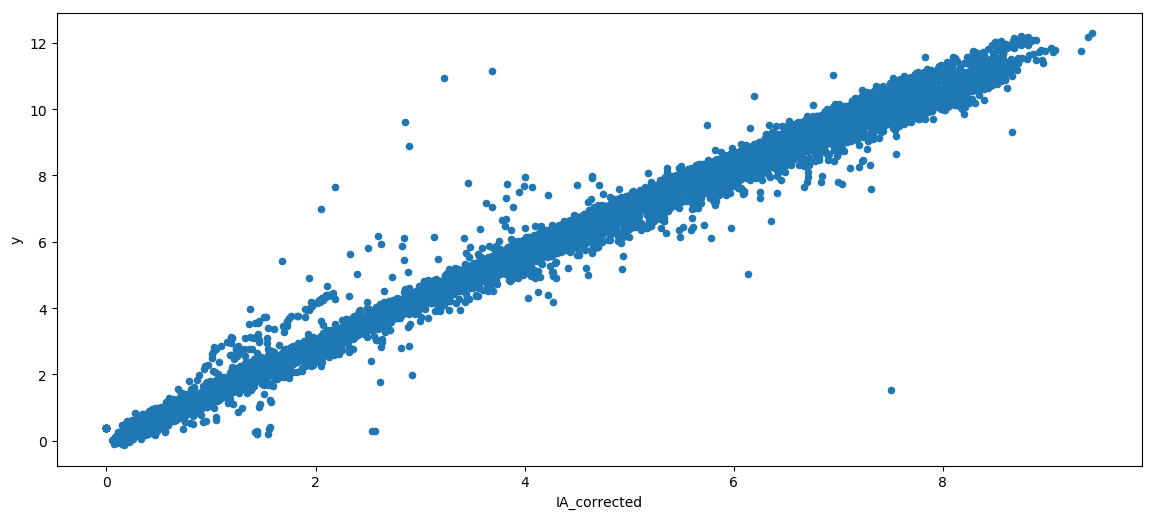

In [14]:
#问题2.5：电流和light_strength的关系？
#回答2.5：

figure(num=None, figsize=(14, 6), dpi=100, facecolor='w', edgecolor='k')

ax = plt.gca()

dfp=df
# dfp.plot(x='ID',y='light_strength',secondary_y=True,ax=ax)
# dfp.plot(x='ID',y='I_A',ylim=(0,20),label='I_A',ax=ax)

# dfp.plot(x='ID',y='y',label='y',ax=ax)

dfp.plot.scatter(x='IA_corrected',y='y',ax=ax)
# dfp.plot.scatter(x='I_A',y='y',ax=ax)

plt.show()

In [15]:
# compareA_df = df[np.abs(df['IA_corrected']-df['I_A'])>0.0000001]
# compareA_df.head(20)[['ID','light_strength','I_A','V_A','V_B','V_C','P_avg','P_avg_corrected','y','IA_corrected','VA_corrected','VB_corrected','VC_corrected']]

In [16]:
df['P_avg_corrected'] = df['P_avg']

df.loc[df['to_correct']==1 , ['P_avg_corrected']]=1/3*df['IA_corrected']*(df['VA_corrected']+df['VB_corrected']+df['VC_corrected'])

In [17]:
df['PA_corrected'] = df['P_A']

df.loc[df['V_A_filtered'].isnull(),'PA_corrected'] = df['IA_corrected']*df['VA_corrected']

df['PB_corrected'] = df['P_B']

df.loc[df['V_B_filtered'].isnull(),'PB_corrected'] = df['IA_corrected']*df['VB_corrected']

df['PC_corrected'] = df['P_C']

df.loc[df['V_C_filtered'].isnull(),'PC_corrected'] = df['IA_corrected']*df['VC_corrected']

In [18]:
compareA_df = df[np.abs(df['IA_corrected']-df['I_A'])>0.0000001]
compareA_df[['ID','light_strength','V_A','V_B','V_C','y','I_A','IA_corrected','VA_corrected','VB_corrected','VC_corrected']]

,ID,light_strength,V_A,V_B,V_C,y,I_A,IA_corrected,VA_corrected,VB_corrected,VC_corrected
14,22,100,65382,7,107,5.440741,7.19,2.841667,722.666667,721.333333,720.833333
499,543,88,290,293,15,NaN,6.81,2.823333,681.000000,680.666667,679.000000
527,591,34,36,65402,0,NaN,6.68,1.786667,678.666667,681.333333,677.000000
529,593,34,37,65403,3,NaN,6.68,2.876667,687.000000,682.000000,677.500000
531,595,34,37,39,65406,NaN,6.77,1.825000,683.000000,680.000000,681.000000
673,737,29,37,37,65514,NaN,6.53,0.315000,645.666667,643.000000,642.500000
859,948,9,65394,4,14,NaN,6.87,0.456667,687.666667,684.000000,695.500000
1178,1286,100,310,307,65438,4.694385,7.18,3.015000,716.000000,716.666667,714.666667
1373,1519,9,77,65387,14,0.839478,7.04,0.870000,712.000000,712.833333,708.166667
1520,1666,112,293,255,65460,4.521973,6.87,2.650000,686.166667,686.500000,686.000000


In [19]:
train = df[df['is_train']==1]
test = df[df['is_train']==0]

In [20]:
#特征同时包含P_avg和P_avg_corrected（local cv 为0.8613）不如只包含P_avg_corrected
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression_l2',
    'metric': 'mse',
    'num_leaves': 31,
    'learning_rate': 0.08,
    'feature_fraction': 0.6,
    'bagging_fraction': 0.8,
    'bagging_freq': 1,
    'verbose': 0
}
# 同样的条件下，此参数设置达到local cv: 0.8575832021441638


test_predicts = []
val_preds = []

# log_test_predicts = []
# log_val_predicts = []
for idx, seed in enumerate([1,2,3,4,5]):
    kf = KFold(5, shuffle=True, random_state=seed)
    
    val_preds.append(np.zeros(train.shape[0]))
    for n_fold, (tra_idx, val_idx) in enumerate(kf.split(train)):
        tra = train.iloc[tra_idx]
        val = train.iloc[val_idx]
        tst = test.copy()

#         grouper = ['bin_ls','bin_env_t','bin_board_t']
#         x = tra.groupby(grouper)['y'].agg({'target_encoding_mean':'mean',
#                                            'target_encoding_max':'max',
#                                            'target_encoding_min':'min',
#                                            'target_encoding_median':'median',
#                                            'target_encoding_var':'var',
#                                            'target_encoding_count':'count'}).reset_index()
#         tra = tra.merge(x, on=grouper, how='left')
#         val = val.merge(x, on= grouper , how ='left')
#         tst = tst.merge(x, on=grouper, how='left')
        predictor = [c for c in tra.columns.tolist() if c not in['y','is_train']]
#         predictor = [c for c in tra.columns.tolist() if c in['P_A','P_B','P_C','P_avg_corrected','I_A','light_strength','board_t','avg_value','wind_direction','wind_speed','rolling_six_y']]

        train_set = lightgbm.Dataset(
            tra[predictor],
            tra['y']
        )

        validation_set = lightgbm.Dataset(
            val[predictor],
            val['y']
        )

        model = lightgbm.train(params, train_set, num_boost_round=5000,
                              valid_sets= [validation_set],
                              valid_names=['valid'],
                              early_stopping_rounds=100,
                               feval=my_val,
                              verbose_eval=500)

        val_preds[idx][val_idx] = model.predict(val[predictor])
        test_predicts.append(model.predict(tst[predictor]))

print('local cv:',1/(1+np.sqrt(mean_squared_error(train['y'],np.mean(val_preds,axis=0)))))

Training until validation scores don't improve for 100 rounds.
[500]	valid's l2: 0.0569903	valid's score: 0.807281
[1000]	valid's l2: 0.0567745	valid's score: 0.807576
Early stopping, best iteration is:
[953]	valid's l2: 0.0567275	valid's score: 0.80764
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[315]	valid's l2: 0.0151487	valid's score: 0.890408
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[212]	valid's l2: 0.0123237	valid's score: 0.90008
Training until validation scores don't improve for 100 rounds.
[500]	valid's l2: 0.0257443	valid's score: 0.861735
Early stopping, best iteration is:
[467]	valid's l2: 0.0256182	valid's score: 0.862027
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[244]	valid's l2: 0.0163073	valid's score: 0.886761
Training until validation scores don't improve for 100 rounds.
[500]	valid's l2: 0.054902	valid

In [21]:
pd.Series(model.feature_importance(importance_type='gain'),
          index=model.feature_name()).sort_values(ascending=False)

P_avg_corrected      297335.893220
PA_corrected         111141.337662
P_A                   13894.116739
IA_filtered           10856.663719
P_avg                  7304.980075
IA_corrected           3007.145434
I_C                    2025.449842
avg_value              1308.735015
P_C                     769.464126
PB_corrected            565.920165
I_A                     538.969619
prev_value              281.025824
I_B                     250.894400
rolling_six_y           241.676988
P_B                     136.944096
wind_direction          109.082894
light_strength          100.356967
second_prev_value        77.803197
wind_speed               66.280743
env_t                    51.359892
board_t                  43.785008
ID                       31.473996
efficiency_C             30.676304
efficiency               24.428870
efficiency_A             23.851809
V_A_filtered             21.536204
next_value               21.466244
V_B_filtered             21.353345
PC_corrected        

In [22]:
test['ans'] = np.mean(test_predicts, axis=0)

for index, row in test.iterrows():
    if row['I_A'] == 0:
        test.at[index,'ans'] = 0.379993 
        print("Hi!"+str(index))

test[test['I_A']==0][['ID','I_A','V_A','V_B','V_C','ans']]

Hi!0
Hi!855
Hi!1543
Hi!1714
Hi!2583
Hi!2930

C:\Users\Alex\Anaconda3\envs\python36\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.



Hi!4123
Hi!4300
Hi!4462
Hi!4632
Hi!4633
Hi!4674
Hi!4675
Hi!4867
Hi!4870
Hi!5072
Hi!5463
Hi!5665
Hi!6071
Hi!6074
Hi!7684
Hi!7783
Hi!7848
Hi!8026
Hi!8624
Hi!8832
Hi!9041
Hi!9255
Hi!9452
Hi!9660
Hi!9871
Hi!10272
Hi!10453
Hi!10653
Hi!11497
Hi!13364
Hi!13566
Hi!13777
Hi!13991
Hi!14833
Hi!15042
Hi!15678
Hi!15882
Hi!16459
Hi!16876
Hi!17061


,ID,I_A,V_A,V_B,V_C,ans
0,1,0.0,0,0,0,0.379993
855,940,0.0,0,0,0,0.379993
1543,1694,0.0,0,0,0,0.379993
1714,1879,0.0,0,0,0,0.379993
2583,2823,0.0,0,0,0,0.379993
2930,3202,0.0,0,0,0,0.379993
4123,4459,0.0,0,0,0,0.379993
4300,4648,0.0,0,0,0,0.379993
4462,4821,0.0,0,0,0,0.379993
4632,5010,0.0,0,0,0,0.379993


In [24]:
test[['ID','ans']].to_csv('../result/080802_086791.csv',header=False, index=False)